In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import math
from IPython.display import display, HTML
from scipy.interpolate import interp1d


In [15]:
# result-CDF_1333.tcl.txt
def loadNormalizeList(directory, flow_size):
    offset = len("AFQ10UlimPL ")
    result = []
    for size in flow_size:
        with open(directory + 'result-CDF_' + str(size) + '.tcl.txt', 'r') as f:
            line = f.read()
            result.append(float(line[offset:]))
    return [flow_size, result]

class FCT:

    def __init__(self,*args):
        if (len(args) == 6):
            self.loadFromFloder(args[0], args[1], args[2], args[3], args[4], args[5])
        elif (len(args) == 4):
            self.loadFromFileList(args[0], args[1], args[2], args[3])
        else:
            raise Exception('parameter number must be 6 or 4')
    
    def expandNormalizedList(self, normalize_lists):
        interpolate_function = interp1d(normalize_lists[0], normalize_lists[1], kind='linear')
        max_value = max(normalize_lists[0])
        min_value = min(normalize_lists[0])
        xint = np.linspace(min_value, max_value, max_value - min_value + 1)
        return interpolate_function(xint)
        
    def loadFromFileList(self, loads, algs, filelist, normalize_lists):
        if (len(loads) * len(algs) != len(filelist)):
            raise Exception('the filelist is not match with loads and algs')
        self.loads = loads
        self.algs = algs
        self.raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
        if len(normalize_lists) != 2 or len(normalize_lists[0]) != len(normalize_lists[1]):
            raise Exception('normalize_lists shoule contains two list with same length')
        normalizor = self.expandNormalizedList(normalize_lists)
        index=0
        for alg_i in range(len(algs)):
            for load_i in range(len(loads)):
                self.raw_data[alg_i][load_i] = self.parse_trace("", filelist[index], normalizor)
                index+=1
                        
    def loadFromFloder(self, folder, toponame, flownum, loads, algs, normalize_lists):
        self.loads = loads
        self.algs = algs
        self.raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
        normalizor = self.expandNormalizedList(normalize_lists)
        for alg_i in range(len(algs)):
            for load_i in range(len(loads)):
                alg = algs[alg_i]
                load = loads[load_i]
                # print("tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                self.raw_data[alg_i][load_i] = \
                    self.parse_trace(folder, \
                                     "tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr", \
                                     normalizor)
    
    # At least two
    def plotting_mean_FCT(self):
        self.plot_FCT_load(self.algs, self.loads, float('inf'))
    
    # Normalized FCT = Actual FCT / min FCT
    # min FCT = flow_size / max bandwidth
    def parse_trace(self, directory, filename, normalizor):
        col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
                   "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
        df = pd.read_csv(directory + filename, sep = ' ', header = None)
        df.columns = col
        df["Normalized FCT"] = df["tmp_pkts"].apply(lambda x: normalizor[int(x)]) / df["Average rate"]
        return df
    
    def get_load_id(self, load):
        return self.loads.index(load)
    
    def get_alg_id(self, alg):
        return self.algs.index(alg)
    
    def humanbytes(self, B):
        B = float(B)
        KB = float(1000)
        MB = float(KB ** 2)
        GB = float(KB ** 3)
        TB = float(KB ** 4) 

        if B < KB:
            return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
        elif KB <= B < MB:
            return '{0:.2f} KB'.format(B/KB)
        elif MB <= B < GB:
            return '{0:.2f} MB'.format(B/MB)
        elif GB <= B < TB:
            return '{0:.2f} GB'.format(B/GB)
        elif TB <= B:
            return '{0:.2f} TB'.format(B/TB)
        
    def plot_FCT_flowsize(self, alg, load, color=None, label=None):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df=self.raw_data[alg_id][load_id]
        y = df['Normalized FCT']
        x = df['tmp_pkts']
        plt.yscale('log')
        plt.scatter(x, y, color=color, label=label)
        plt.xlabel('flow size')
        plt.ylabel('Normalized FCT')
        plt.legend()
        plt.show()
    
    ## internal
    def plot_one_FCT_percentile(self, alg, load, percentile, flow_size, isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # 16 indicate col 'Normalized FCT' 
            # print(res.iloc[[math.ceil((res.shape[0]-1) * 0.95)]])
            selected_flow.append(res.iloc[math.ceil((res.shape[0]-1) * percentile), 16])
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size')
            plt.ylabel('Normalized FCT')
            plt.title("load:"+str(load)+" percentile:"+str(percentile))
            plt.grid()
            plt.legend()
            #plt.yticks([0,50,100,150,200])
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size])
            plt.show()

    def plot_one_FCT_mean(self, alg, load, flow_size, isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # 16 indicate col 'Normalized FCT' 
            selected_flow.append(res.iloc[:, 16].mean())
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size')
            plt.ylabel('Normalized FCT')
            plt.title("load:"+str(load)+" mean")
            plt.grid()
            plt.legend()
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size])
            plt.show()
            
    #plot FCT of a sepecific percentile divided by flow_size
    def plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_percentile(alg, load, percentile, flow_size, True)
            else:
                self.plot_one_FCT_percentile(alg, load, percentile, flow_size, False)
    
    # internal
    def plot_one_FCT_load(self, alg, loads, flow_lim, isLast=False):
        alg_id=self.get_alg_id(alg)
        df = self.raw_data[alg_id][:]
        y = []
        for load in loads:
            load_id=self.get_load_id(load)
            df_one = df[load_id]
            y.append(df_one[df_one['tmp_pkts']<flow_lim]['Normalized FCT'].mean())
        plt.yscale('log')
        plt.plot(loads, y, label=alg)
        if (isLast):
            plt.xlabel('load')
            plt.ylabel('Normalized FCT')
            plt.grid()
            plt.legend()
            plt.show()
    
    # plot FCT_load graph
    # the mean of all the flows of flow size under flow_lim
    def plot_FCT_load(self, algs, loads, flow_lim):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_load(alg, loads, flow_lim, True)
            else:
                self.plot_one_FCT_load(alg, loads, flow_lim, False)       
            

### interface:
plot_FCT_load

plot_FCT_percentile_fix_load

plotting_mean_FCT

plot_FCT_flowsize

### Initialization

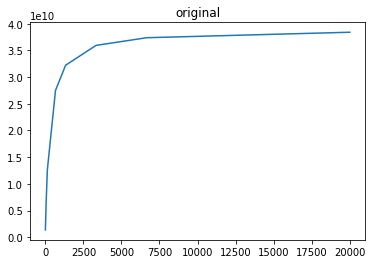

In [32]:
if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, 20000, float('inf')]
    normalize_lists = loadNormalizeList('/home/ovs2/lining/Gearbox/automatic/flowBenchmark/', flow_size[1:-1])
    plt.plot(normalize_lists[0], normalize_lists[1])
    plt.title("original")
    plt.show()

In [52]:
if __name__ == '__main__':
    folder = "/home/ovs2/lining/Gearbox/automatic/"
    FCT_analysis = FCT(
        [.5], \
        ["AFQ10UlimPL"],\
        [
            folder + "tcp_AFQ10UlimPL_flow_5_0.5_Topology-incast-singlenode-unify.tcl.tr"
        ],\
        normalize_lists)

In [5]:
if __name__ == '__main__':
    # using some file
    folder = "/home/ovs2/lining/Gearbox/automatic/"
    FCT_analysis = FCT(
        [.1, 0.2, 0.3], \
        ["DropTail", "AFQ10PL"],\
        [
            folder + "tcp_DropTail_flow_100_0.1_Topology-incast-singlenode-unify.tcl.tr",\
            folder + "tcp_DropTail_flow_100_0.2_Topology-incast-singlenode-unify.tcl.tr",\
            folder + "tcp_DropTail_flow_100_0.3_Topology-incast-singlenode-unify.tcl.tr",\
            folder + "tcp_AFQ10PL_flow_100_0.1_Topology-incast-singlenode-unify.tcl.tr",\
            folder + "tcp_AFQ10PL_flow_100_0.2_Topology-incast-singlenode-unify.tcl.tr",\
            folder + "tcp_AFQ10PL_flow_100_0.3_Topology-incast-singlenode-unify.tcl.tr"\
        ],\
        normalize_lists)

In [36]:
if __name__ == '__main__':
    # automatic folder All
    FCT_analysis_small = FCT("/home/ovs2/lining/Gearbox/automatic/", \
                       "Topology-incast-singlenode-unify.tcl",\
                       1000, \
                       [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], \
                       ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                       normalize_lists)

### plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size)

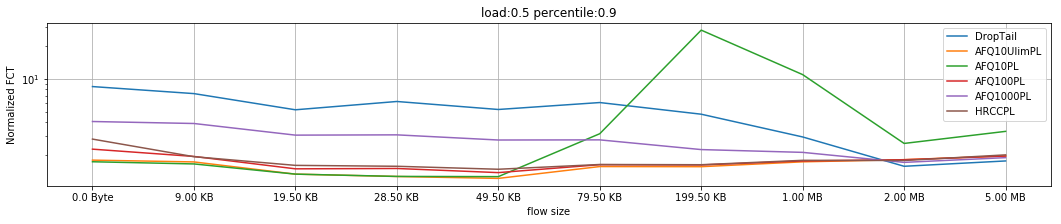

In [48]:
if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    FCT_analysis_small.plot_FCT_percentile_fix_load(\
                    ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    .5,\
                    .9,\
                    flow_size)

### plot_FCT_load(self, algs, loads, flow_lim)

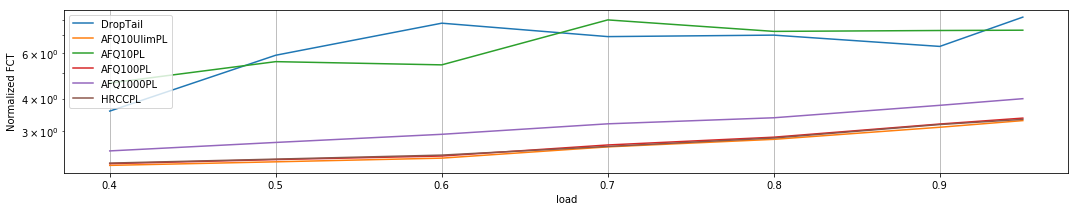

In [38]:
if __name__ == '__main__':
    FCT_analysis_small.plot_FCT_load(["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], \
                                     [.4, .5, .6, .7, .8, .9, .95], 10)

### plotting_mean_FCT(self)

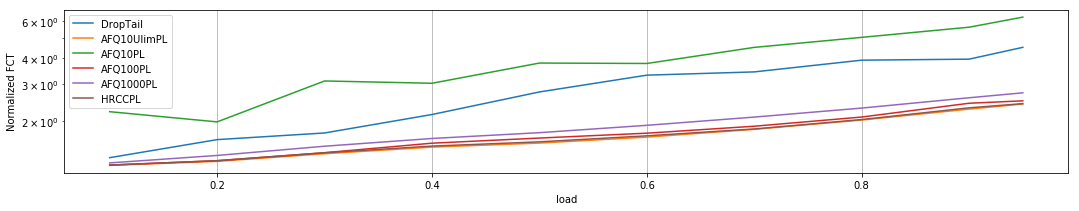

In [39]:
if __name__ == '__main__':
    FCT_analysis_small.plotting_mean_FCT()

### plot_FCT_flowsize(self, alg, load, color=None, label=None)

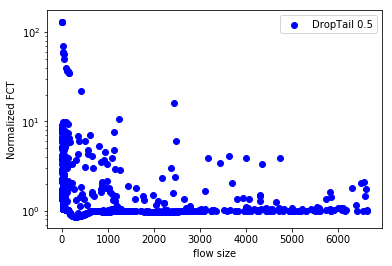

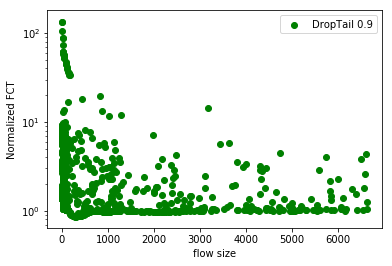

In [40]:
if __name__ == '__main__':
    FCT_analysis_small.plot_FCT_flowsize("DropTail", .5, label = "DropTail 0.5", color = 'b')
    FCT_analysis_small.plot_FCT_flowsize("DropTail", .9, label = "DropTail 0.9", color = 'g')
